In [6]:
import pandas as pd 
import numpy as np
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split


In [7]:
heartdata = pd.read_csv('data/heart.csv')
heartdata.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,1,145,233,1,2,150,0,2.3,3,0,fixed,0
1,67,1,4,160,286,0,2,108,1,1.5,2,3,normal,1
2,67,1,4,120,229,0,2,129,1,2.6,2,2,reversible,0
3,37,1,3,130,250,0,0,187,0,3.5,3,0,normal,0
4,41,0,2,130,204,0,2,172,0,1.4,1,0,normal,0


In [9]:
train, test  = train_test_split(heartdata)
train, valid = train_test_split(train)
train.shape, test.shape, valid.shape

((170, 14), (76, 14), (57, 14))

In [13]:
def df_to_dataset(dataframe, epochs, batch_size=32, shuffle = True):
    dataframe = dataframe.copy()
    labels = dataframe.pop('target')
    ds  = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
    if shuffle:
        ds.shuffle(len(dataframe))
    ds = ds.repeat(epochs).batch(batch_size)
    return ds
    
epochs = 30
batch_size = 32
train_datasets = df_to_dataset(train, epochs, batch_size)
test_datasets = df_to_dataset(test, epochs, batch_size,shuffle=False)
valid_datasets = df_to_dataset(valid, epochs, batch_size, shuffle=False)

In [15]:
for feature_batch, label_batch in train_datasets.take(1):
    print('Every feature:', list(feature_batch.keys()))
    print('A batch of ages:', feature_batch['age'])
    print('A batch of targets:', label_batch )

Every feature: ['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal']
A batch of ages: tf.Tensor(
[66 45 46 58 54 57 60 63 60 58 63 60 43 63 43 60 58 48 58 65 44 59 65 52
 45 59 58 62 54 48 63 39], shape=(32,), dtype=int32)
A batch of targets: tf.Tensor([1 0 0 1 1 0 0 1 1 1 0 0 0 1 0 1 1 0 0 0 0 1 1 0 0 0 1 0 1 0 1 0], shape=(32,), dtype=int32)


In [17]:
# 创建几类特征列，并演示特征列如何转换 dataframe 中的列。
example_batch = next(iter(train_datasets))[0]
def demo(feature_column):
    featrre_layer = keras.layers.DenseFeatures(feature_column)
    print(featrre_layer(example_batch).numpy())
    

## 数值列
一个特征列的输出将成为模型的输入（使用上面定义的 demo 函数，我们将能准确地看到 dataframe 中的每列的转换方式）。 数值列（numeric column） 是最简单的列类型。它用于表示实数特征。使用此列时，模型将从 dataframe 中接收未更改的列值。

In [22]:
age = tf.feature_column.numeric_column(key='age')
demo(age)
# 在这个心脏病数据集中，dataframe 中的大多数列都是数值列。




If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

[[66.]
 [45.]
 [46.]
 [58.]
 [54.]
 [57.]
 [60.]
 [63.]
 [60.]
 [58.]
 [63.]
 [60.]
 [43.]
 [63.]
 [43.]
 [60.]
 [58.]
 [48.]
 [58.]
 [65.]
 [44.]
 [59.]
 [65.]
 [52.]
 [45.]
 [59.]
 [58.]
 [62.]
 [54.]
 [48.]
 [63.]
 [39.]]


## 分桶列
通常，您不希望将数字直接输入模型，而是根据数值范围将其值分成不同的类别。考虑代表一个人年龄的原始数据。我们可以用 分桶列（bucketized column）将年龄分成几个分桶（buckets），而不是将年龄表示成数值列。请注意下面的 one-hot 数值表示每行匹配的年龄范围。

In [26]:
age_buckets = tf.feature_column.bucketized_column(
    source_column=age, boundaries=[18, 25, 30, 35, 40, 45, 50, 55, 60, 65])#boundaries界限，10个数把年龄分成了11段
demo(age_buckets)


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0.

## 分类列
在此数据集中，thal 用字符串表示（如 'fixed'，'normal'，或 'reversible'）。我们无法直接将字符串提供给模型。相反，我们必须首先将它们映射到数值。分类词汇列（categorical vocabulary columns）提供了一种用 one-hot 向量表示字符串的方法（就像您在上面看到的年龄分桶一样）。词汇表可以用 categorical_column_with_vocabulary_list 作为 list 传递，或者用 categorical_column_with_vocabulary_file 从文件中加载。

In [27]:
thal = tf.feature_column.categorical_column_with_vocabulary_list(
       key='thal', vocabulary_list=['fixed', 'normal', 'reversible'])

thal_one_hot = tf.feature_column.indicator_column(categorical_column = thal)
demo(thal_one_hot)


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Instructions for updating:
The old _FeatureColumn APIs are being deprecated. Please use the new FeatureColumn APIs instead.
Instructions for updating:
The old _FeatureColumn APIs are being deprecated. Please use the new FeatureColumn APIs instead.
[[0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 

## 嵌入列
假设我们不是只有几个可能的字符串，而是每个类别有数千（或更多）值。 由于多种原因，随着类别数量的增加，使用 one-hot 编码训练神经网络变得不可行。我们可以使用嵌入列来克服此限制。嵌入列（embedding column）将数据表示为一个低维度密集向量，而非多维的 one-hot 向量，该低维度密集向量可以包含任何数，而不仅仅是 0 或 1。嵌入的大小（在下面的示例中为 8）是必须调整的参数。

关键点：当分类列具有许多可能的值时，最好使用嵌入列。我们在这里使用嵌入列用于演示目的，为此您有一个完整的示例，以在将来可以修改用于其他数据集。

In [28]:
# 注意到嵌入列的输入是我们之前创建的类别列
thal_embedding = tf.feature_column.embedding_column(categorical_column = thal, dimension=8)dimension指定嵌入的大小
demo(thal_embedding)


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

[[ 0.20841005 -0.23379213 -0.10842037 -0.5390056  -0.36866614  0.6355157
  -0.525405   -0.17179178]
 [ 0.20841005 -0.23379213 -0.10842037 -0.5390056  -0.36866614  0.6355157
  -0.525405   -0.17179178]
 [ 0.20841005 -0.23379213 -0.10842037 -0.5390056  -0.36866614  0.6355157
  -0.525405   -0.17179178]
 [-0.4740936   0.18899167  0.27109727  0.30911398  0.4256477   0.01601095
  -0.49537775  0.0852642 ]
 [-0.06985556  0.05098387 -0.3703031   0.4367753  -0.13130617 -0.26420864
   0.10661944 -0.45772737]
 [ 0.2

## 经过哈希处理的特征列
表示具有大量数值的分类列的另一种方法是使用 categorical_column_with_hash_bucket。该特征列计算输入的一个哈希值，然后选择一个 hash_bucket_size 分桶来编码字符串。使用此列时，您不需要提供词汇表，并且可以选择使 hash_buckets 的数量远远小于实际类别的数量以节省空间。

关键点：该技术的一个重要缺点是可能存在冲突，不同的字符串被映射到同一个范围。实际上，无论如何，经过哈希处理的特征列对某些数据集都有效

In [30]:
thal_hashed = tf.feature_column.categorical_column_with_hash_bucket(
      key = 'thal', hash_bucket_size=1000)
demo(tf.feature_column.indicator_column(thal_hashed))


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Instructions for updating:
The old _FeatureColumn APIs are being deprecated. Please use the new FeatureColumn APIs instead.
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


# 组合的特征列
将多种特征组合到一个特征中，称为特征组合（feature crosses），它让模型能够为每种特征组合学习单独的权重。此处，我们将创建一个 age 和 thal 组合的新特征。请注意，crossed_column 不会构建所有可能组合的完整列表（可能非常大）。相反，它由 hashed_column 支持，因此您可以选择表的大小。

In [32]:
crossed_feature = tf.feature_column.crossed_column([age_buckets, thal], hash_bucket_size=1000)
demo(tf.feature_column.indicator_column(crossed_feature))


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Instructions for updating:
The old _FeatureColumn APIs are being deprecated. Please use the new FeatureColumn APIs instead.
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


## 选择要使用的列
我们已经了解了如何使用几种类型的特征列。 现在我们将使用它们来训练模型。本教程的目标是向您展示使用特征列所需的完整代码（例如，机制）。我们任意地选择了几列来训练我们的模型。

关键点：如果您的目标是建立一个准确的模型，请尝试使用您自己的更大的数据集，并仔细考虑哪些特征最有意义，以及如何表示它们。

In [37]:
feature_columns = []

# 数值列
for header in ['age', 'trestbps', 'chol', 'thalach', 'oldpeak', 'slope', 'ca']:
    feature_columns.append(tf.feature_column.numeric_column(header))

# 分桶列
age_buckets = tf.feature_column.bucketized_column(age, boundaries=[18, 25, 30, 35, 40, 45, 50, 55, 60, 65])
feature_columns.append(age_buckets)

# 分类列
thal = tf.feature_column.categorical_column_with_vocabulary_list(
      'thal', ['fixed', 'normal', 'reversible'])
thal_one_hot = tf.feature_column.indicator_column(thal)
feature_columns.append(thal_one_hot)

# 嵌入列
thal_embedding = tf.feature_column.embedding_column(thal, dimension=8)
feature_columns.append(thal_embedding)

# 组合列
crossed_feature = tf.feature_column.crossed_column([age_buckets, thal], hash_bucket_size=1000)
crossed_feature = tf.feature_column.indicator_column(crossed_feature)
feature_columns.append(crossed_feature)

### 建立一个新的特征层
现在我们已经定义了我们的特征列，我们将使用密集特征（DenseFeatures）层将特征列输入到我们的 Keras 模型中。

In [46]:
feature_layer = tf.keras.layers.DenseFeatures(feature_columns)

In [42]:
batch_size = 32
epochs = 30
train_ds = df_to_dataset(train, epochs = 30, batch_size=batch_size)
valid_ds = df_to_dataset(valid, epochs = 30, shuffle=False, batch_size=batch_size)
test_ds = df_to_dataset(test, epochs = 30, shuffle=False, batch_size=batch_size)

## 创建，编译和训练模型

In [51]:
model = tf.keras.Sequential([
  feature_layer,
  keras.layers.Dense(128, activation='relu'),
  keras.layers.Dense(128, activation='relu'),
  keras.layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'],
              run_eagerly=True)

# model.summary()

In [53]:
history = model.fit(train_ds,
          validation_data=valid_ds,
          epochs=5)


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Epoch 1/5
160/160 [==============================] - 80s 498ms/step - loss: 0.4716 - accuracy: 0.7880 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/5
160/160 [==============================] - 80s 502ms/step - loss: 0.2888 - accuracy: 0.8706 - val_loss: 0.4997 - val_accuracy: 0.7544
Epoch 3/5
160/160 [==============================] - 82s 512ms/step - loss: 0.2405 - accuracy: 0.8975 - val_loss: 0.5142 - val_accuracy: 0.7719
Epoch 4/5
160/160 [==============================] - 84s 523ms/step 

In [54]:
model.evaluate(test_ds)

72/72 [==============================] - 20s 275ms/step - loss: 0.4776 - accuracy: 0.8158


[0.4775933292176988, 0.81578946]

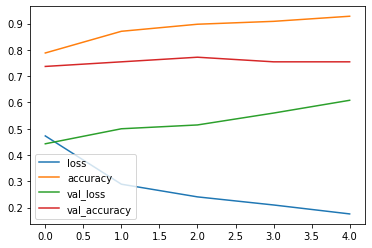

In [58]:
pd.DataFrame(history.history).plot()
